# [IAPR 2020:][iapr2020] Lab 2 ‒  Object description

**Authors:** Wei JIANG, Minghui SHI, Costanza VOLPINI

**Due date:** 24.04.2020

[iapr2020]: https://github.com/LTS5/iapr-2020

## Extract relevant data
We first need to extract the `lab-02-data.tar.gz` archive.
To this end, we use the [tarfile] module from the Python standard library.

[tarfile]: https://docs.python.org/3.6/library/tarfile.html

In [1]:
import tarfile
import os

data_base_path = os.path.join(os.pardir, 'data')
data_folder = 'lab-02-data'
tar_path = os.path.join(data_base_path, data_folder + '.tar.gz')
with tarfile.open(tar_path, mode='r:gz') as tar:
    tar.extractall(path=data_base_path)

## Part 1
In the `lab-02-data/part1` folder, you will find 28x28 grey-scale pictures of handwritten "0" and "1".
These digits have been extracted from MNIST dataset (http://yann.lecun.com/exdb/mnist/).

Your goal is to extract, from each of those images, a 2-dimensional feature vector (i.e. 2 features) and to plot them all on a 2D graph.
If you have chosen good features, the vectors of the "0"'s should nicely cluster in one part of the plane and those of the "1"'s in another.

Please try first the Fourier Descriptors.
You can make several attempts: e.g. with and without invariance to rotation, translation, scaling, etc.
You can also for instance rotate the images and assess the invariance in rotation.

**Note:** for the Fourier descriptors, the u_k signal has to be constructed by following the contour point after point.
Some pre-processing (image binarization, possibly some Mathematical Morphology) might be useful.

Then feel free to try other features, the more you try, the better it will be (for you).

### 1.1 Data visualization

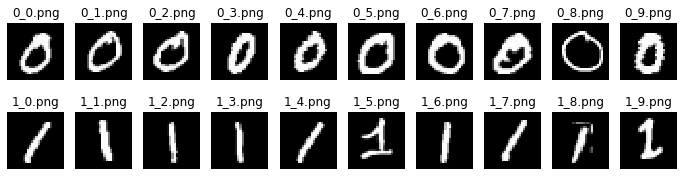

In [2]:
import skimage.io
import matplotlib.pyplot as plt
%matplotlib inline

# Load images
data_base_path = os.path.join(os.pardir, 'data')
data_folder = 'lab-02-data'
#  Load zeros
zeros_path = os.path.join(data_base_path, data_folder, 'part1', '0')
zeros_names = [nm for nm in os.listdir(zeros_path) if '.png' in nm]  # make sure to only load .png
zeros_names.sort()  # sort file names
ic = skimage.io.imread_collection([os.path.join(zeros_path, nm) for nm in zeros_names])
zeros_im = skimage.io.concatenate_images(ic)
#  Load ones
ones_path = os.path.join(data_base_path, data_folder, 'part1', '1')
ones_names = [nm for nm in os.listdir(ones_path) if '.png' in nm]  # make sure to only load .png
ones_names.sort()  # sort file names
ic = skimage.io.imread_collection(([os.path.join(ones_path, nm) for nm in ones_names]))
ones_im = skimage.io.concatenate_images(ic)

# Plot images
fig, axes = plt.subplots(2, len(zeros_im), figsize=(12, 3))
for ax, im, nm in zip(axes[0], zeros_im, zeros_names):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)
for ax, im, nm in zip(axes[1], ones_im, ones_names):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)


### 1.2 Fourier descriptors
Add your implementation and discussion

### Invariances rotation, translation, scaling -- MS, CV, WJ

In [3]:
zeros_im[zeros_im>0] = 255
ones_im[ones_im>0] = 255

In [4]:
from skimage import feature
import matplotlib.pyplot as plt
import numpy as np
from scipy import ndimage
import skimage.measure as measure

from skimage.transform import rotate, AffineTransform, warp
import random
import cv2
import math
from numpy.linalg import inv

from scipy.interpolate import Rbf
from scipy.ndimage import morphology


In [5]:
# Helper functions
# Convert contour into complex signals
def convert_signal(contour):
#     contour -= contour.mean() # do we demean the data?
    output = np.zeros((np.array(contour).shape[0],1))
    output = contour[:,1] + 1j*contour[:,0] 
    return output

# Find outer contour and convert
def contour_fourier(images):
    contour_out = []
    
    for im in images:
        im = ndimage.binary_fill_holes(im)
        im[im>0] =255
        contours = measure.find_contours(im, 0)
        contour = sorted(contours, key=lambda x: len(x))[-1]
        contour_out.append(convert_signal(contour))
    return np.array(contour_out)



# Helper functions to do transforms

# def rotateImage(img):
    # Test with different rotations (or we should just keep one? or all of them?)
    # I have tried also with numpy e.g. np.rot90(img) but I got almost the same result
    # skimage: from skimage import measure, transform
    # a = transform.rotate(img, 90, resize=False, preserve_range=True).astype('uint8')
    
#     r = random.randint(1, 3)
#     r = 1 # for testing
#     if (r == 1):
#         a = cv2.rotate(img, cv2.ROTATE_90_CLOCKWISE)
#     elif (r == 2):
#         a = cv2.rotate(img, cv2.ROTATE_90_COUNTERCLOCKWISE)
#     else:
#         a = cv2.rotate(img, cv2.ROTATE_180)
#     return a #the invariance seems not working (?)


# def translateImage(img):
#     x = random.randint(-2, 2)
#     y = random.randint(-2, 2)
#     shift = AffineTransform(translation=(x, y))
#     return warp(img, shift, mode="wrap")
    
# def scaleImage(img): # TODO: I will check and try to fix it
#     scale_img = np.pad(img, ((5,5),(5,5)), mode='constant',constant_values=0)
#     resized = cv2.resize(scale_img, (img.shape[0],img.shape[1]))
#     return resized

# def dataAugmentation(img):
#     '''
#     Return [original_img, rot_clockwise, rot_anticlockwise, translated, scaled]
#     '''
#     imgs = [img]
#     rot = rotateImage(img)
#     imgs.append(rot)
#     shifted = translateImage(img)
#     imgs.append(shifted)
#     scaled = scaleImage(img)
#     imgs.append(scaled)
#     return imgs

# def affineTransform(img, rotation, scaling, translation):
#     if rotation:
#         img = rotateImage(img)
#     if scaling:
#         img = scaleImage(img)
#     if translation:
#         img = translateImage(img)
#     return img



# Convert image coordinates to matrix
def convertImg(img):   
    N = img.shape[0]
    # zero padding
    if N%2 == 0:
        img = np.pad(img, ((5,6),(5,6)), mode='constant',constant_values=0)
        N+=11
    else:
        img = np.pad(img, ((5,5),(5,5)), mode='constant',constant_values=0)
        N+=10
    x = np.arange(-(N//2), N//2+1)
    y = np.arange(-(N//2), N//2+1)


    xx, yy = np.meshgrid(x, y)
    out = []
    out.append(xx.reshape([1,-1]))
    out.append(yy.reshape([1,-1]))
    out.append(np.ones(yy.reshape([1,-1]).shape))
    out = np.array(out).squeeze()
    return xx,yy,img,out

def affineTransform(img, rotation, scaling, translation):
    xx,yy,img,imgvec = convertImg(img)

    if rotation:
        theta =  random.uniform(-np.pi, np.pi)
        a0 = 0
        a1 = math.cos(theta)
        a2 = math.sin(theta)
        b0 = 0
        b1 = -math.sin(theta)
        b2 = math.cos(theta)
        operator = np.array([[a1, a2, a0],[b1, b2, b0], [0, 0, 1]])
        imgvec = inv(operator) @ imgvec

    if scaling:
        s =  random.uniform(0.8, 1.2)
        a0 = 0
        a1 = 1/s
        a2 = 0
        b0 = 0
        b1 = 0
        b2 = 1/s 
        operator = np.array([[a1, a2, a0],[b1, b2, b0], [0, 0, 1]])
        imgvec = inv(operator) @ imgvec
    if translation:
        tx =  random.randint(-2, 2)
        ty =  random.randint(-2, 2)
        a0 = -tx
        a1 = 1
        a2 = 0
        b0 = -ty
        b1 = 0
        b2 = 1        
        operator = np.array([[a1, a2, a0],[b1, b2, b0], [0, 0, 1]])
        imgvec = inv(operator) @ imgvec
    xt = imgvec[0,:]
    yt = imgvec[1,:]
    rbf = Rbf(xx, yy, img, epsilon=2)
    imgt = rbf(xt, yt)
    # normalize and threshold
    imgt = imgt- imgt.min()
    imgt = imgt/ (imgt.max()-imgt.min())
    t = 0.4
    imgt[imgt>= t] = 1
    imgt[imgt<t] = 0
    imgt = imgt*255
    
    return imgt.reshape(xx.shape)


# Plot images with contours
def plotImagContour(axes, contourf_0, contourf_1, zeros_im, ones_im, zeros_names, ones_names):
    for ax0, ax1, contour0, contour1,im0, im1, nm0, nm1 in zip(axes[0], axes[1], contourf_0, contourf_1, zeros_im, ones_im, zeros_names, ones_names):
        ax0.imshow(im0)
        ax0.step(np.real(contour0), np.imag(contour0), linewidth=2, c='r')
        ax0.axis('off')
        ax0.set_title(nm0)

        ax1.imshow(im1)
        ax1.step(np.real(contour1), np.imag(contour1), linewidth=2, c='r')
        ax1.axis('off')
        ax1.set_title(nm1)
        
        
# Skeletonize
def skeletonize(im):
    element = cv2.getStructuringElement(cv2.MORPH_CROSS, (3,3))
    size = np.size(im)
    skel = np.zeros(im.shape, np.uint8)
    while True:
        eroded = cv2.erode(im, element)
        im = eroded.copy()
        if cv2.countNonZero(im)==0:
            break
        open = cv2.morphologyEx(eroded, cv2.MORPH_OPEN, element)
        temp = cv2.subtract(eroded, open)
        skel = cv2.bitwise_or(skel,temp)
    skel[skel>0]=1
    return skel

In [6]:
def get_fourier_discriptor(images_1, images_2, f1, f2, f_div):
    
    # Contour detection
    contourf_0 = contour_fourier(images_1)
    contourf_1 = contour_fourier(images_2)


    FD_0_orig = np.zeros((10,2))
    FD_1_orig = np.zeros((10,2))

    for i in range(len(images_1)):

        fft0 = np.fft.fft(contourf_0[i])#,n = N)
        fft1 = np.fft.fft(contourf_1[i])#, n = N)


        # normalization
        if f_div == -1:
            FD_0_orig[i,:]  = np.abs([fft0[f1],fft0[f2]])  # Translaton (Exclude f0), scaling (ratio)，and rotation(amplitude) invariances
            FD_1_orig[i,:]  = np.abs([fft1[f1],fft1[f2]])
                   
        else:
            FD_0_orig[i,:]  = np.abs([fft0[f1],fft0[f2]])/np.abs(fft0[f_div])  # Translaton (Exclude f0), scaling (ratio)，and rotation(amplitude) invariances
            FD_1_orig[i,:]  = np.abs([fft1[f1],fft1[f2]])/np.abs(fft1[f_div])

        # print(FD_0)
    zeros = plt.scatter(FD_0_orig[:,0], FD_0_orig[:,1]) 
    ones = plt.scatter(FD_1_orig[:,0], FD_1_orig[:,1])
    plt.legend((zeros,ones),("0","1"))
    plt.show()
    return FD_0_orig, FD_1_orig

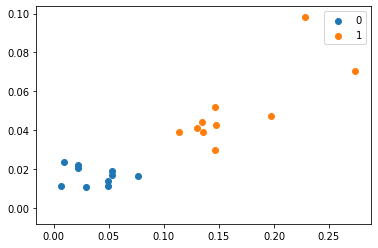

In [7]:
f1 = 3
f2 = 5
f_div = 1
FD_0_orig, FD_1_orig = get_fourier_discriptor(zeros_im, ones_im, f1, f2, f_div)

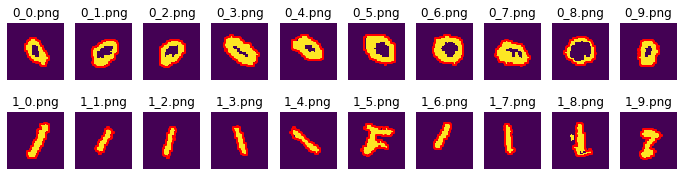

In [8]:
# Apply affine transformations with boolean flags
rotation = True
scaling = True
translation = True

im_af0 = []
im_af1 = []

for img0, img1, nm0, nm1 in zip(zeros_im, ones_im, zeros_names, ones_names):
    img0 = affineTransform(img0, rotation, scaling, translation)
    img1 = affineTransform(img1, rotation, scaling, translation)

    im_af0.append(img0)
    im_af1.append(img1)

# Contour detection
contourf_af0 = contour_fourier(im_af0)
contourf_af1 = contour_fourier(im_af1)

# Plots
fig, axes = plt.subplots(2, len(zeros_im), figsize=(12, 3))
plotImagContour(axes, contourf_af0, contourf_af1, im_af0, im_af1, zeros_names, ones_names)


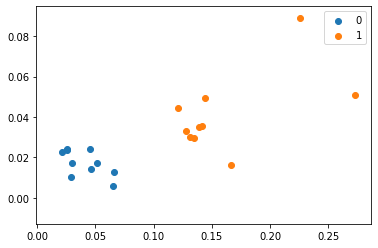

In [9]:

f1 = 3
f2 = 5
f_div = 1
FD_0, FD_1 = get_fourier_discriptor(im_af0, im_af1, f1, f2, f_div)

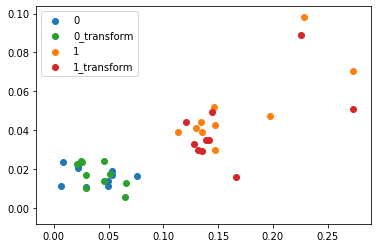

In [10]:

# Superimposed plot of original and transformed to test invariances
zeros = plt.scatter(FD_0_orig[:,0],FD_0_orig[:,1]) 
ones = plt.scatter(FD_1_orig[:,0],FD_1_orig[:,1])
zeros_tf = plt.scatter(FD_0[:,0],FD_0[:,1]) 
ones_tf = plt.scatter(FD_1[:,0],FD_1[:,1])
plt.legend((zeros,zeros_tf,ones,ones_tf), ("0","0_transform","1", "1_transform"))

### 1.3 Additional method(s)
Add your implementation and discussion

### Skeleton

### PCA -- MS

### Compacity -- CV



### Moments -- WJ


### Freeman Code


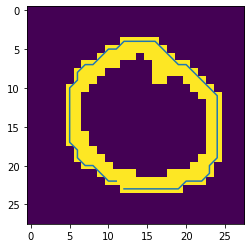

In [35]:
# Code taken from pseudocode: http://www.cs.unca.edu/~reiser/imaging/chaincode.html 
def chain_code(im):
    '''
    Directions  0 1 2    Change in    -1  0  1   Change in    -1 -1 -1
               7 x 3    x-dimension  -1  0  1   y-dimension   0  0  0
               6 5 4                 -1  0  1                 1  1  1
    '''
    chain = []
    contour = [] #just for debug
    
    im = im.copy()
    
    # Find the first pixel on the boundary of the object. 
    for r in range(0, im.shape[0]):
        for c in range(0, im.shape[1]):
            if im[r][c] == 255:
                start_r = r
                start_c = c
                break
    
    # chain code
    directions = [0, 1, 2, 7, 3, 6, 5, 4]
    change_y = [-1, -1, -1, 0, 0, 1, 1, 1]
    change_x = [-1, 0, 1, -1, 1, -1, 0, 1]
    
    r = start_r
    c = start_c
    
    for index, d in enumerate(directions):
        if im[start_r + change_y[index], start_c + change_x[index]] == 255:
            r = start_r + change_y[index]
            c = start_c + change_x[index]
            contour.append((r, c))
            chain.append(d)
            break

    while (r != start_r) or (c != start_c):
        # decide where start
        b_direction = (d + 5) % 8
        dir1 = range(b_direction, 8)
        dir2 = range(0, b_direction)
        directions_ext = list(dir1) + list(dir2)
        for d in directions_ext:
            index = directions.index(d)
            if im[r + change_y[index], c + change_x[index]] == 255:
                r = r + change_y[index]
                c = c + change_x[index] 
                contour.append((r, c))
                chain.append(d)
                break
    
    plt.imshow(im)
    plt.plot([i[1] for i in contour], [i[0] for i in contour])
    plt.show()
    return chain

chain_zero = chain_code(zeros_im[8])


im_chain0 = []
im_chain1 = []

for img0, img1, nm0, nm1 in zip(zeros_im, ones_im, zeros_names, ones_names):
    img0 = affineTransform(img0, rotation, scaling, translation)
    img1 = affineTransform(img1, rotation, scaling, translation)

    im_af0.append(img0)
    im_af1.append(img1)

# Contour detection
contourf_af0 = contour_fourier(im_af0)
contourf_af1 = contour_fourier(im_af1)

# Plots
fig, axes = plt.subplots(2, len(zeros_im), figsize=(12, 3))
plotImagContour(axes, contourf_af0, contourf_af1, im_af0, im_af1, zeros_names, ones_names)

### Elongation(Eclipse fitted)

In [12]:
from skimage.measure import regionprops, label
from matplotlib.patches import Ellipse

In [13]:
def elongation_plot(img):
    label_img = label(img)
    [props] = regionprops(label_img)
    fig, ax = plt.subplots()
    ax.imshow(img, cmap=plt.cm.gray)
    (y0, x0) = props.centroid
    orientation = props.orientation
    x1 = x0 + math.cos(orientation) * 0.5 * props.major_axis_length
    y1 = y0 - math.sin(orientation) * 0.5 * props.major_axis_length
    x2 = x0 - math.sin(orientation) * 0.5 * props.minor_axis_length
    y2 = y0 - math.cos(orientation) * 0.5 * props.minor_axis_length

    ax.plot((x0, x1), (y0, y1), '-r', linewidth=2.5)
    ax.plot((x0, x2), (y0, y2), '-r', linewidth=2.5)
    ax.plot(x0, y0, '.g', markersize=15)

    ellipse = Ellipse(xy=(x0, y0), width=props.minor_axis_length, height=props.major_axis_length, angle = 90 - orientation/3.14*180,
                        edgecolor='b', fc='None', lw=2)
    ax.add_patch(ellipse)
    plt.show()

C:\Users\costa\Anaconda3\lib\site-packages\skimage\measure\_regionprops.py:250: UserWarning: regionprops and image moments (including moments, normalized moments, central moments, and inertia tensor) of 2D images will change from xy coordinates to rc coordinates in version 0.16.
See https://scikit-image.org/docs/0.14.x/release_notes_and_installation.html#deprecations for details on how to avoid this message.
  warn(XY_TO_RC_DEPRECATION_MESSAGE)
C:\Users\costa\Anaconda3\lib\site-packages\skimage\measure\_regionprops.py:260: UserWarning: regionprops and image moments (including moments, normalized moments, central moments, and inertia tensor) of 2D images will change from xy coordinates to rc coordinates in version 0.16.
See https://scikit-image.org/docs/0.14.x/release_notes_and_installation.html#deprecations for details on how to avoid this message.
  warn(XY_TO_RC_DEPRECATION_MESSAGE)


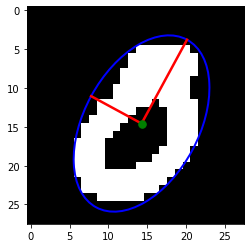

In [14]:
elongation_plot(zeros_im[0])

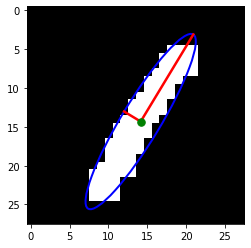

In [15]:
elongation_plot(ones_im[0])

In [16]:
def cal_major_minor_axis(img):
    label_img = label(img)
    [props] = regionprops(label_img)
    return [props.major_axis_length/props.minor_axis_length,props.minor_axis_length/props.major_axis_length]

In [17]:
axis_length_zeros=[]
for im in zeros_im:
     axis_length_zeros.append(cal_major_minor_axis(im))
axis_length_zeros = np.array(axis_length_zeros)
print(axis_length_zeros)

[[1.66129393 0.60194044]
 [1.5628025  0.63987612]
 [1.53488475 0.65151471]
 [1.83045114 0.54631341]
 [1.65029954 0.6059506 ]
 [1.34649183 0.74267068]
 [1.10131561 0.90800492]
 [1.4681463  0.68113103]
 [1.10164699 0.90773179]
 [1.47438582 0.67824852]]


In [18]:
axis_length_ones=[]
for im in ones_im:
    el = cv2.getStructuringElement(cv2.MORPH_CROSS, (3,3))
    im = ndimage.binary_opening(im,el )
    axis_length_ones.append(cal_major_minor_axis(im))
axis_length_ones = np.array(axis_length_ones)
print(axis_length_ones)

[[5.29918444 0.18870828]
 [4.37390828 0.22862848]
 [5.64017952 0.17729932]
 [4.9248096  0.20305354]
 [5.11540097 0.1954881 ]
 [1.62458724 0.61554097]
 [4.7206662  0.21183451]
 [4.93789577 0.20251541]
 [3.86224166 0.25891699]
 [2.57718658 0.38802002]]


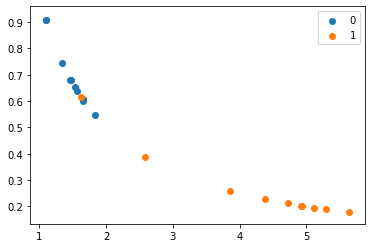

In [19]:
zeros = plt.scatter(axis_length_zeros[:,0], axis_length_zeros[:,1])
ones = plt.scatter(axis_length_ones[:,0], axis_length_ones[:,1])
plt.legend((zeros,ones),("0","1"))
plt.show()

Morphological Skeleton

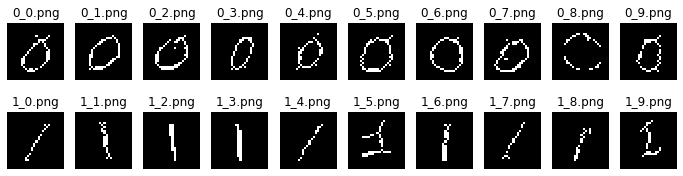

In [20]:
# Skeleton version 2
def skeletonize2(im):
    n = True
    out = np.zeros(im.shape, np.uint8)
    iter = 0
    curr = im.copy()
    topHatImage = np.zeros(im.shape, np.uint8)
    el = cv2.getStructuringElement(cv2.MORPH_CROSS, (3,3)) #replace with square
    while True:
        curr = cv2.erode(curr, el, iterations = 1)
        topHatImage = cv2.morphologyEx(curr, cv2.MORPH_TOPHAT, el)
        out = np.add(out, topHatImage)
        n = np.amax(curr) > 0
        iter = iter + 1
        if not n:
            break
    for x in range(0, out.shape[0]):
        for y in range(0, out.shape[1]):
            if out[x][y] > 0:
                out[x][y] = 255.0
            else:
                out[x][y] = 0
    return out
    
Sr_zeros_im = []
Sr_ones_im = []
for im0, im1 in zip(zeros_im, ones_im):
    skel0 = skeletonize2(im0)
    Sr_zeros_im.append(skel0) 
    skel1 = skeletonize2(im1)
    Sr_ones_im.append(skel1)
    
fig, axes = plt.subplots(2, len(zeros_im), figsize=(12, 3))
for ax, im, nm in zip(axes[0], Sr_zeros_im, zeros_names):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)
for ax, im, nm in zip(axes[1], Sr_ones_im, ones_names):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)

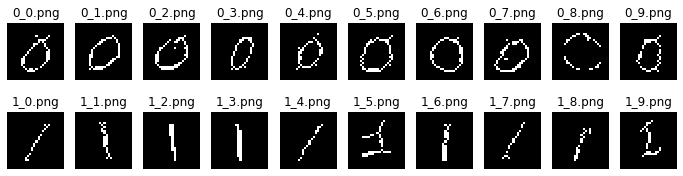

In [21]:
# Skeletonize images
Sr_zeros_im = []
Sr_ones_im = []
for im0, im1 in zip(zeros_im, ones_im):
    skel0 = skeletonize(im0)
    Sr_zeros_im.append(skel0) 
    skel1 = skeletonize(im1)
    Sr_ones_im.append(skel1)
    
fig, axes = plt.subplots(2, len(zeros_im), figsize=(12, 3))
for ax, im, nm in zip(axes[0], Sr_zeros_im, zeros_names):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)
for ax, im, nm in zip(axes[1], Sr_ones_im, ones_names):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)

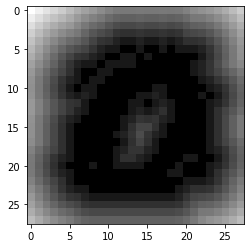

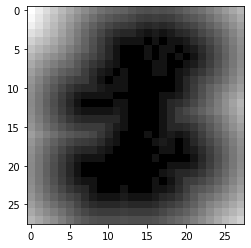

In [22]:
# plot distance maps with mean skeleton
mean_skel0 = np.array(np.mean(Sr_zeros_im,0))
mean_skel1 = np.array(np.mean(Sr_ones_im,0))
mean_skel0[mean_skel0>0] = 1
mean_skel1[mean_skel1>0] = 1

distance_map_0 = morphology.distance_transform_edt(1-mean_skel0)
plt.imshow(distance_map_0, cmap ='gray')
plt.show()
distance_map_1 = morphology.distance_transform_edt(1-mean_skel1)
plt.imshow(distance_map_1, cmap ='gray')

[[0.19262595 0.96101077]
 [0.17516152 1.05499408]
 [0.25916014 1.12231896]
 [0.31127863 0.82664408]
 [0.27156854 0.99056874]
 [0.31403966 1.27027762]
 [0.29067057 1.39405454]
 [0.35598386 1.32092506]
 [0.53592331 1.98456209]
 [0.25309837 0.93577874]]
[[0.78086939 0.38251406]
 [0.76750189 0.27142624]
 [0.81595225 0.18256196]
 [0.8708424  0.17333333]
 [0.74449888 0.40691426]
 [0.61008046 0.42795166]
 [0.85826433 0.17578309]
 [0.71616759 0.33236852]
 [0.69660062 0.27691125]
 [0.63851612 0.38635707]]


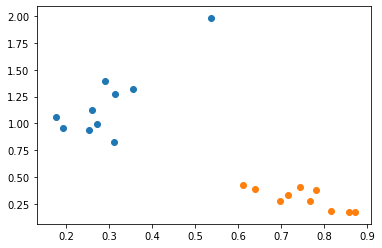

In [23]:
# Calculate image distances
distance_zeros=[]
for im in zeros_im:
    distance_0 = np.sum(np.multiply(distance_map_0, im))/np.sum(im)
    distance_1 = np.sum(np.multiply(distance_map_1, im))/np.sum(im)
    distance_zeros.append([distance_0,distance_1])
distance_zeros = np.array(distance_zeros)
print(distance_zeros)
distance_ones=[]
for im in ones_im:
    distance_0 = np.sum(np.multiply(distance_map_0, im))/np.sum(im)
    distance_1 = np.sum(np.multiply(distance_map_1, im))/np.sum(im)
    distance_ones.append([distance_0,distance_1])
distance_ones = np.array(distance_ones)
print(distance_ones)

# plot distances from mean skeletons of 0s and 1s
plt.scatter(distance_zeros[:,0],distance_zeros[:,1])
plt.scatter(distance_ones[:,0],distance_ones[:,1])
plt.show()

#### Distance Map method + Contours

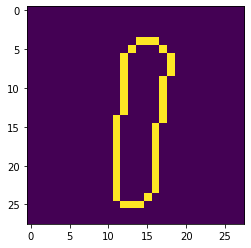

In [24]:
contours = np.array(measure.find_contours(ones_im[6], 0))[0]
cont_1 = np.zeros_like(ones_im[0])
cont_1[contours[:,0].astype(int),contours[:,1].astype(int)]=1
plt.imshow(cont_1)

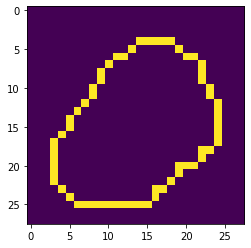

In [25]:
contours = np.array(measure.find_contours(zeros_im[7], 0))[0]
cont_0 = np.zeros_like(zeros_im[0])
cont_0[contours[:,0].astype(int),contours[:,1].astype(int)]=1
plt.imshow(cont_0)

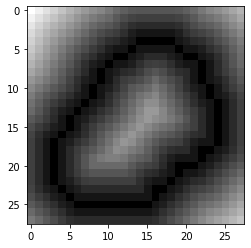

In [26]:
distance_map_0 = morphology.distance_transform_edt(1-cont_0)
plt.imshow(distance_map_0, cmap ='gray')

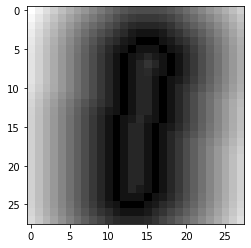

In [27]:
distance_map_1 = morphology.distance_transform_edt(1-cont_1)
plt.imshow(distance_map_1, cmap ='gray')

In [28]:
distance_zeros=[]
for im in zeros_im:
    contours = np.array(measure.find_contours(im, 0))[0]
    cont_0 = np.zeros_like(zeros_im[0])
    cont_0[contours[:,0].astype(int),contours[:,1].astype(int)]=1
    distance_0 = np.sum(np.multiply(distance_map_0, cont_0))
    distance_1 = np.sum(np.multiply(distance_map_1, cont_0))
    distance_zeros.append([distance_0,distance_1])
distance_zeros = np.array(distance_zeros)
print(distance_zeros)

[[ 52.3782036  167.14206195]
 [ 50.89949494 198.18137138]
 [ 53.1869126  214.59002257]
 [ 69.71172365 139.717819  ]
 [ 62.85033956 164.04882314]
 [ 48.14213562 262.21154073]
 [ 71.86295677 250.42663105]
 [  0.         237.74044007]
 [103.64130204 275.4926569 ]
 [ 67.15090264 176.51144141]]


In [29]:
distance_ones=[]
for im in ones_im:
    contours = np.array(measure.find_contours(im, 0))[0]
    cont_1 = np.zeros_like(ones_im[0])
    cont_1[contours[:,0].astype(int),contours[:,1].astype(int)]=1
    distance_0 = np.sum(np.multiply(distance_map_0, cont_1))
    distance_1 = np.sum(np.multiply(distance_map_1, cont_1))
    distance_ones.append([distance_0,distance_1])
distance_ones = np.array(distance_ones)
print(distance_ones)

[[147.31404441  96.06855194]
 [143.1467278   63.60112616]
 [144.39465813  48.48528137]
 [146.71996594  34.95084462]
 [141.69703754  89.76068131]
 [205.24054566 187.08262339]
 [139.38017717   0.        ]
 [150.81300833  87.15265196]
 [168.04586055  73.77654924]
 [185.43886437 111.05739419]]


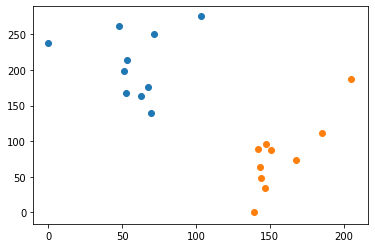

In [30]:
plt.scatter(distance_zeros[:,0],distance_zeros[:,1])
plt.scatter(distance_ones[:,0],distance_ones[:,1])
plt.show()

## PCA


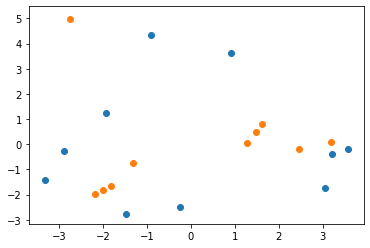

In [31]:
# initializing the pca
from sklearn import decomposition
pca = decomposition.PCA()
# configuring the parameteres
# the number of components = 2
pca.n_components = 2
# zeros_im_data = zeros_im.reshape(10,-1)
# zeros_im_data = zeros_im_data - np.mean(zeros_im_data,axis = 0)
# ones_im_data = ones_im.reshape(10,-1)
# ones_im_data = ones_im_data - np.mean(ones_im_data,axis = 0)

pca0 = pca.fit_transform(np.array(Sr_zeros_im).reshape(10,-1))
pca1 = pca.fit_transform(np.array(Sr_ones_im).reshape(10,-1))
# pca_reduced will contain the 2-d projects of simple data
plt.scatter(pca0[:,0],pca0[:,1])
plt.scatter(pca1[:,0],pca1[:,1])

## Part 2
The `lab-02-data/part2` folder contains grey-scale pictures of handwritten "2" and "3".
Extract the same feature (typically 2 Fourier descriptors) as in part 1 also on these images and plot them on the same graph as the features of the "0" and "1".
Is it possible to discriminate all these 4 digits with a 2-dimensional feature vector?

### 2.1 Data visualization

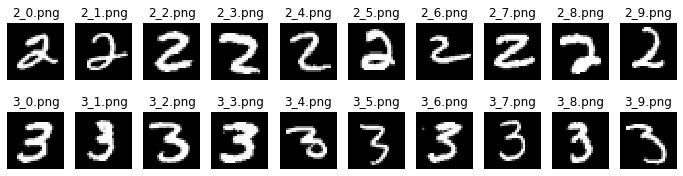

In [32]:
#  Load zeros
twos_path = os.path.join(data_base_path, data_folder, 'part2', '2')
twos_names = [nm for nm in os.listdir(twos_path) if '.png' in nm]  # make sure to only load .png
twos_names.sort()  # sort file names
ic = skimage.io.imread_collection([os.path.join(twos_path, nm) for nm in twos_names])
twos_im = skimage.io.concatenate_images(ic)
#  Load ones
threes_path = os.path.join(data_base_path, data_folder, 'part2', '3')
threes_names = [nm for nm in os.listdir(threes_path) if '.png' in nm]  # make sure to only load .png
threes_names.sort()  # sort file names
ic = skimage.io.imread_collection(([os.path.join(threes_path, nm) for nm in threes_names]))
threes_im = skimage.io.concatenate_images(ic)

# Plot images
fig, axes = plt.subplots(2, len(twos_im), figsize=(12, 3))
for ax, im, nm in zip(axes[0], twos_im, twos_names):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)
for ax, im, nm in zip(axes[1], threes_im, threes_names):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)

### 2.2 Additional method(s) and conclusion
Add your implementations and discussions here

In [33]:
# Next meeting tentative April 7th!